In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import logging
logging.disable(logging.WARNING)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
train_df = pd.read_csv('/content/drive/My Drive/Datasets/train.csv/train.csv')
val_df = pd.read_csv('/content/drive/My Drive/Datasets/validation.csv/validation.csv')
test_df = pd.read_csv('/content/drive/My Drive/Datasets/test.csv/test.csv')
train_texts = train_df['article'].tolist()
train_summaries = train_df['highlights'].tolist()
val_texts = val_df['article'].tolist()
val_summaries = val_df['highlights'].tolist()
test_texts = test_df['article'].tolist()
test_summaries = test_df['highlights'].tolist()

Mounted at /content/drive


In [ ]:
train_texts = train_texts[:1000]
train_summaries = train_summaries[:1000]
val_texts = val_texts[:1000]
val_summaries = val_summaries[:1000]
test_texts = test_texts[:1000]
test_summaries = test_summaries[:1000]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, summaries, tokenizer, max_len):
        self.texts = texts
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        summary = str(self.summaries[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            summary,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,

            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': encoding['input_ids'].flatten()
        }

In [ ]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").half().cuda()

phi2_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
phi2_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    torch_dtype=torch.float16,
    device_map="auto",
    max_memory={0: "10GB", "cpu": "5GB"}
)

class SummarizationModel(torch.nn.Module):
    def __init__(self):
        super(SummarizationModel, self).__init__()
        self.encoder = distilbert_model
        self.decoder = phi2_model

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        decoder_outputs = self.decoder(input_ids=decoder_input_ids, attention_mask=attention_mask)
        return decoder_outputs.logits

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model = SummarizationModel()
learning_rate = 3e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SummarizationModel(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): 

In [ ]:
def preprocess_text(texts, max_length=256):
    return distilbert_tokenizer(texts, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)

def train_model(train_texts, train_summaries, epochs=2, batch_size=4):
    model.train()

    for epoch in range(epochs):
        for i in range(0, len(train_texts), batch_size):
            input_batch = preprocess_text(train_texts[i:i+batch_size]).to(device)
            summary_batch = phi2_tokenizer(train_summaries[i:i+batch_size], return_tensors="pt", truncation=True,
                                           padding="max_length", max_length=128).to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                encoder_outputs = model(input_batch["input_ids"], input_batch["attention_mask"])

                prompt_text = "[SUMMARIZE]: " + distilbert_tokenizer.decode(input_batch["input_ids"][0], skip_special_tokens=True)

                phi2_input = phi2_tokenizer(prompt_text, return_tensors="pt").to(device)

                outputs = phi2_model(**phi2_input)
                loss = torch.nn.functional.cross_entropy(outputs.logits.view(-1, outputs.logits.shape[-1]), summary_batch["input_ids"].view(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if i % (batch_size * 10) == 0:
                print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item()}")

In [ ]:
def generate_summary(text, max_length=128):
    model.eval()
    input_data = preprocess_text([text]).to(device)

    with torch.no_grad():
        encoder_outputs = model.encoder(input_data["input_ids"], attention_mask=input_data["attention_mask"])

        prompt_text = "[SUMMARIZE]: " + distilbert_tokenizer.decode(input_data["input_ids"][0], skip_special_tokens=True)

        phi2_input = phi2_tokenizer(prompt_text, return_tensors="pt").to(device)

        summary_ids = phi2_model.generate(**phi2_input, max_length=max_length, num_beams=5, early_stopping=True)

    return phi2_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
sample_text = "The stock market saw a significant rise today due to increasing investor confidence."
print("Generated Summary:", generate_summary(sample_text))

Generated Summary: [SUMMARIZE]: the stock market saw a significant rise today due to increasing investor confidence.
Output: The stock market experienced a substantial increase today as a result of growing investor confidence.



In [ ]:
generated_summary = generate_summary(sample_text)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=de309bd1f9ee00ab61000c2e4e8636e3aeadbaef9899ebf8a48924be69012817
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate
rouge = evaluate.load("rouge")

def evaluate_rouge(reference_summaries, generated_summaries):
    scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
    print("\n--- ROUGE Evaluation ---")
    print(f"ROUGE-1: {scores['rouge1']:.4f}")
    print(f"ROUGE-2: {scores['rouge2']:.4f}")
    print(f"ROUGE-L: {scores['rougeL']:.4f}")
    return scores

In [ ]:
reference_summaries = ["Investor confidence caused a significant rise in the stock market today."]
generated_summaries = [generated_summary]
evaluate_rouge(reference_summaries, generated_summaries)


--- ROUGE Evaluation ---
ROUGE-1: 0.4390
ROUGE-2: 0.2564
ROUGE-L: 0.3415


{'rouge1': 0.43902439024390244,
 'rouge2': 0.25641025641025644,
 'rougeL': 0.34146341463414637,
 'rougeLsum': 0.34146341463414637}

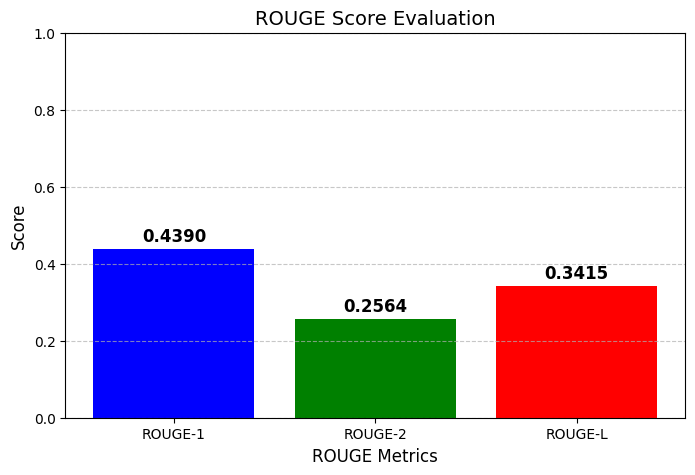

In [ ]:
import matplotlib.pyplot as plt

rouge_scores = {
    "ROUGE-1": 0.4390,
    "ROUGE-2": 0.2564,
    "ROUGE-L": 0.3415
}

labels = list(rouge_scores.keys())
values = list(rouge_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])

plt.title("ROUGE Score Evaluation", fontsize=14)
plt.xlabel("ROUGE Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
